# CNN

1. Wprowadzenie do sieci CNN
2. Import bibliotek
3. Baza danych
4. Wstępna analiza tekstu
5. Modele treningowe (poszukiwanie optymalnego rozwiązania)
6. Praca na modelu
7. Analiza sentymentu
8. Podsumowanie

1. Wprowadzenie do sieci CNN

Konwolucyjna sieć neuronowa (CNN) to rodzaj architektury sieci neuronowej głębokiego uczenia się powszechnie stosowanej w przetwarzaniu obrazu komputerowego. Widzenie komputerowe to dziedzina sztucznej inteligencji, która umożliwia komputerowi zrozumienie i interpretację obrazu lub danych wizualnych.

Jeśli chodzi o uczenie maszynowe, sztuczne sieci neuronowe sprawdzają się naprawdę dobrze. Sieci neuronowe są używane w różnych zbiorach danych, takich jak obrazy, dźwięk i tekst. Różne typy sieci neuronowych są wykorzystywane do różnych celów, na przykład do przewidywania sekwencji słów używamy Recurrent Neural Networks, a dokładniej LSTM, podobnie do klasyfikacji obrazów używamy sieci Convolution Neural.

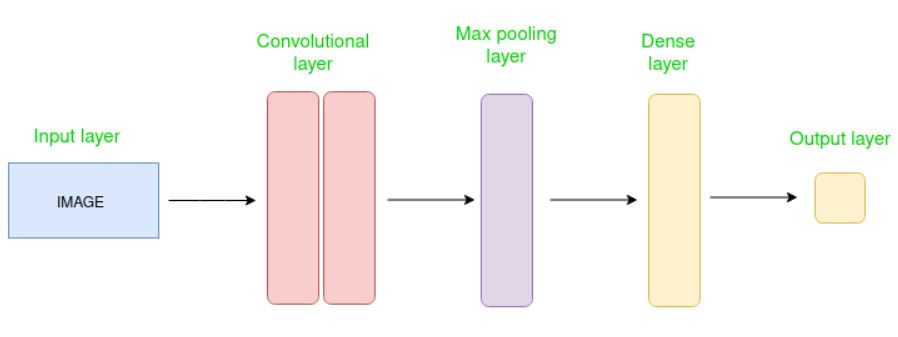

2. Import bibliotek

In [92]:
import pandas as pd
import numpy as np


!pip install -q tensorflow
!pip install -q spacy
!python -m spacy download en_core_web_md -q
!pip install Wordcloud -q
!pip install accelerate -q
!pip install transformers -q
!pip install datasets -q

import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
import tensorflow as tf

from wordcloud import WordCloud, STOPWORDS

from tqdm import tqdm
tqdm.pandas()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, f1_score, roc_curve

from tensorflow.keras.layers import GRU, LSTM, SimpleRNN, Embedding, Dropout
from tensorflow.keras.layers import Activation, Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D

from keras.models import Sequential

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

from torchtext.data.utils import get_tokenizer
from torch.utils.data import random_split
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import time

import en_core_web_sm

2023-12-27 12:59:02.922577: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-27 12:59:02.922750: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-27 12:59:02.927038: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-27 12:59:04.472641: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 11.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [93]:
!pip install -U accelerate==0.20.3 -q
import accelerate
!pip install transformers -q
import transformers

#!pip install accelerate -U -q

3. Baza danych

Baza danych pochodzi z zasobów kaggle i znajduje się pod linkiem:
https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews

Baza obejmuje 20 491 recenzje klientów dotyczących hoteli, z których skorzystali. Rating w skali 1 - 5 z dominacją 4 i 5.

In [94]:
# Dane umieściłam na google drive, skąd je pobieram

from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/tripadvisor_hotel_reviews.csv'
row_data = pd.read_csv(path)
row_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


In [95]:
# Zamieniam Rating na 3 klasy

row_data['Rating_class'] = row_data['Rating'].replace({5: 'Positive', 4: 'Positive', 3: 'Neutral',
                                                      2:'Negative', 1:'Negative'})
row_data

,Review,Rating,Rating_class
0,nice hotel expensive parking got good deal sta...,4,Positive
1,ok nothing special charge diamond member hilto...,2,Negative
2,nice rooms not 4* experience hotel monaco seat...,3,Neutral
3,"unique, great stay, wonderful time hotel monac...",5,Positive
4,"great stay great stay, went seahawk game aweso...",5,Positive
...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,Positive
20487,great location price view hotel great quick pl...,4,Positive
20488,"ok just looks nice modern outside, desk staff ...",2,Negative
20489,hotel theft ruined vacation hotel opened sept ...,1,Negative


In [96]:
# Tworzę kopię danych

data = row_data.copy()
del data['Rating']

4. Wstępna analiza tekstu

Przechodze do analizy tekstu dotyczącej m.in identyfikacji każdej z 3 grup klientów, stworzenia WordCloud na podstawie wcześniej zdefiniowanej próbki.
Definiuję funkcję remove_stopwords w celu usunięcia słów takich jak 'the' czy 'and' oraz uruchamiam proces lematyzacji w celu ujednolicenia odmiany słów.

In [97]:
data.shape

(20491, 2)

In [98]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Review        20491 non-null  object
 1   Rating_class  20491 non-null  object
dtypes: object(2)
memory usage: 320.3+ KB


In [99]:
data.groupby('Rating_class').nunique()

,Review
Rating_class,
Negative,3214
Neutral,2184
Positive,15093


<Axes: xlabel='Rating_class', ylabel='count'>

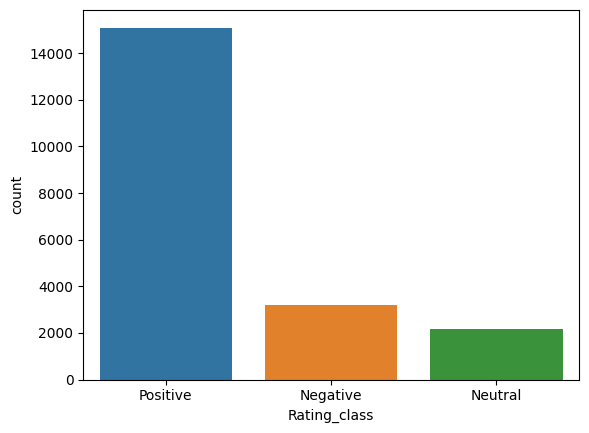

In [100]:
sns.countplot(x='Rating_class', data=data)

In [101]:
data['Review'] = data['Review'].apply(lambda x: x.lower())
data.sample(10)

,Review,Rating_class
13868,"nice, boyfriend stayed hotel nights week septe...",Positive
10061,quiet comfortable chose stay bassano reviews t...,Positive
1300,perfect young kids wonderful hotel young kids ...,Positive
14217,n't ask better recently returned group confere...,Positive
7832,"warned, just returned stay hotel la playa, web...",Negative
15656,stunning sunsets husband spent days ritz carlt...,Positive
5163,fantastic hotel hotel decor gorgeous room en s...,Positive
2181,good location value hotel changed hands curren...,Positive
7184,wonderful resort dominican pool absolutely unb...,Positive
2502,slice heaven old san juan just arrived hours a...,Positive


In [102]:
import spacy

nlp = spacy.load('en_core_web_md', disable=['ner', 'parser'])
nlp.add_pipe('sentencizer')

In [103]:
def remove_stopwords(text):
  return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

data['Review'] = data['Review'].apply(remove_stopwords)
data.sample(10)

,Review,Rating_class
12161,sheraton dissapoint great stay sheraton booked...,Positive
3295,great hotel casino san juan marriott excellent...,Positive
17903,great value stayed hotel enza florence 2 night...,Positive
15945,"perfect location, stayed 30th till june 2nd, b...",Positive
19143,best hotel beijing staying park plaza beijing ...,Positive
14321,excellent hotel returned 5 night stay athenaeu...,Positive
18519,nice resorts problems husband stayed majestic ...,Neutral
7389,pleased drury returned 4 night stay drury inn ...,Positive
11623,loved location perfect 5 minutes walk zoo trai...,Positive
16374,"unforgettable wrong reasons, booked family sui...",Neutral


In [104]:
data.drop_duplicates(subset='Review', keep='first', inplace=True)

In [105]:
a=data[data['Rating_class']== 'Positive'].sample(1000)
b=data[data['Rating_class']== 'Neutral'].sample(1000)
c=data[data['Rating_class']== 'Negative'].sample(1000)

data5k = pd.concat([a,b,c])

In [106]:
def lemmatize(text):
  return ' '.join([x.lemma_ for x in nlp(text)])

data5k['Review'] = data5k['Review'].progress_apply(lemmatize)
data5k.sample(10)

100%|██████████| 3000/3000 [01:40<00:00, 29.70it/s]


,Review,Rating_class
14761,"spend quality time family , hola , come today ...",Neutral
2736,good book trip sun wing flight transportation ...,Neutral
1919,simple room ok location location ok . polk str...,Neutral
8396,"recommend hotel , overwhelmed hotel choice hav...",Positive
17986,ok price stay pleasant reason go lack room wai...,Neutral
9937,"gem , great stay orto medici , room small adeq...",Positive
19662,wonderful location hotel wonderful place stay ...,Positive
3855,"stay well go natura park 5 day girlfriend , mo...",Negative
17637,budget hotel read review hotel go singapore ex...,Neutral
7790,wonderful pre - cruise stay husband stay night...,Positive


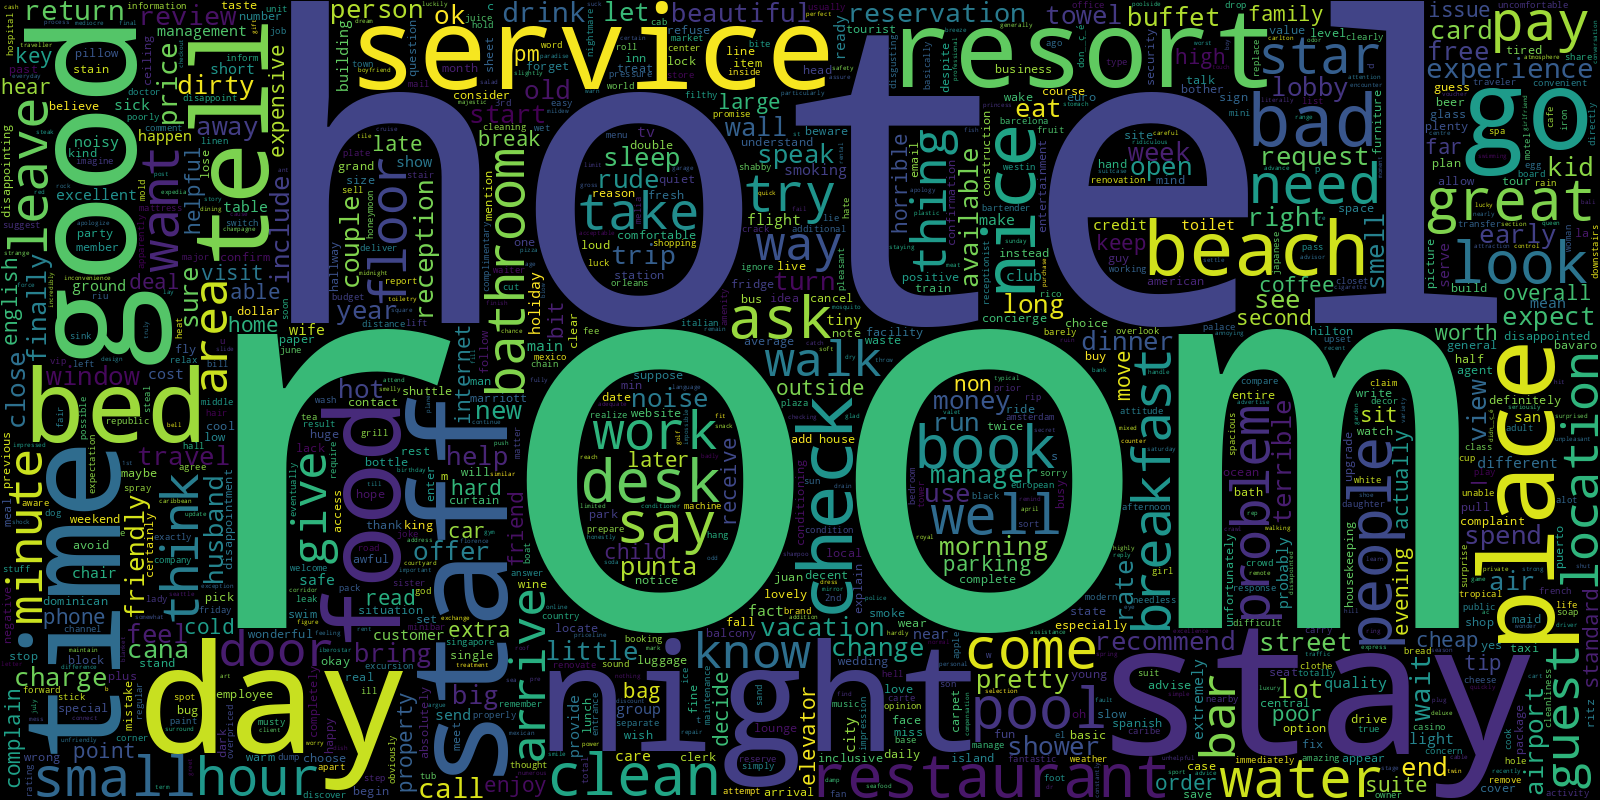

In [107]:
text_neg = ' '.join(data5k[data5k['Rating_class']== 'Negative']['Review'])

wc_neg = WordCloud(max_words = 1000, width = 1600, height = 800, collocations=False).generate(text_neg)
wc_neg.to_image()

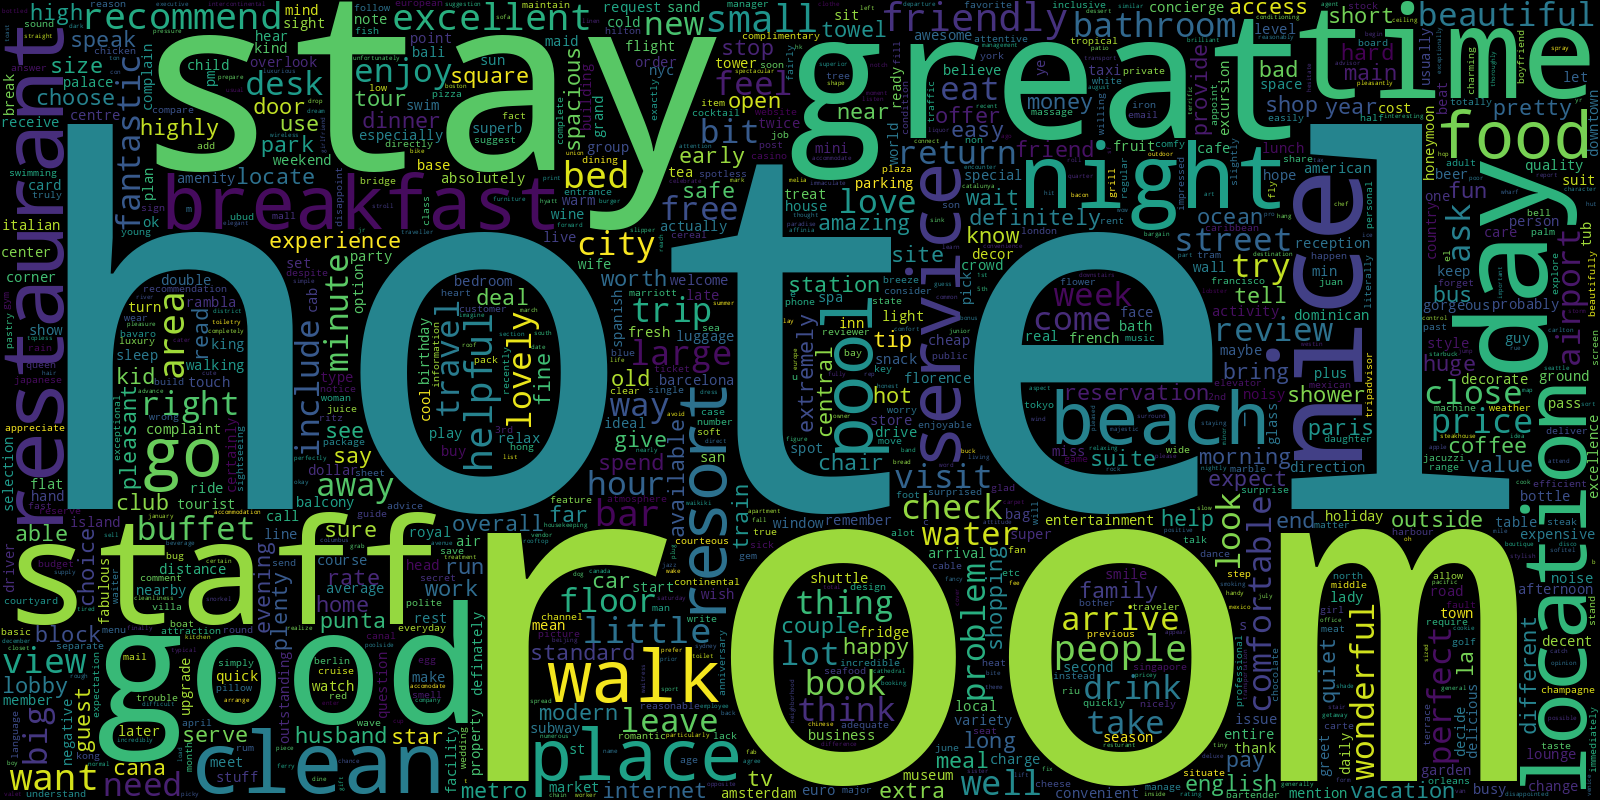

In [108]:
text_pos = ' '.join(data5k[data5k['Rating_class']== 'Positive']['Review'])

wc_pos = WordCloud(max_words = 1000, width = 1600, height = 800, collocations=False).generate(text_pos)
wc_pos.to_image()

In [109]:
# Klasyfikacja

# Metoda train_test_split: 10% test, 90% train

In [110]:
X_train, X_test, y_train, y_test = train_test_split(data5k.Review, data5k.Rating_class, test_size=0.1, stratify=data5k.Rating_class)

In [111]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000)
vectorizer.fit(X_train)

TfidfVectorizer(max_features=1000, ngram_range=(1, 2))

In [112]:
len(vectorizer.get_feature_names_out())

1000

In [113]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [114]:
print(X_train.shape)
print(X_test.shape)

(2700, 1000)
(300, 1000)


In [115]:
model = BernoulliNB()
model.fit(X_train, y_train)

BernoulliNB()

In [116]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.73      0.77      0.75       100
     Neutral       0.56      0.48      0.52       100
    Positive       0.65      0.71      0.68       100

    accuracy                           0.65       300
   macro avg       0.65      0.65      0.65       300
weighted avg       0.65      0.65      0.65       300



5. Modele treningowe (poszukiwanie optymalnego rozwiązania)

Poniżej prezentuje wyniki analizy na podstawie wcześniej przygotowanych modeli. Załączam modele oraz wykresy obrazujące val_loss i val_accuracy.
Moim celem było znalezienie modelu, dla którego val_accuracy będzie najwyższe przy jednoczesnym jak najniższym val_loss przed epoch, w której dochodzi do przeuczenia modelu.

In [117]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

Model 1 model CNN zawiarający pojedynczą warstwe konwolucji, dla której najwyższa dokładność i najniższas strata została odnotowana na 7 epoce val_loss: 0.7387 - val_accuracy: 0.6500.

In [118]:
model = None
r = None

model = load_model('model_single_CNN.h5')

In [119]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 20)          323200    
                                                                 
 conv1d (Conv1D)             (None, None, 128)         7808      
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 331395 (1.26 MB)
Trainable params: 331395 (1.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


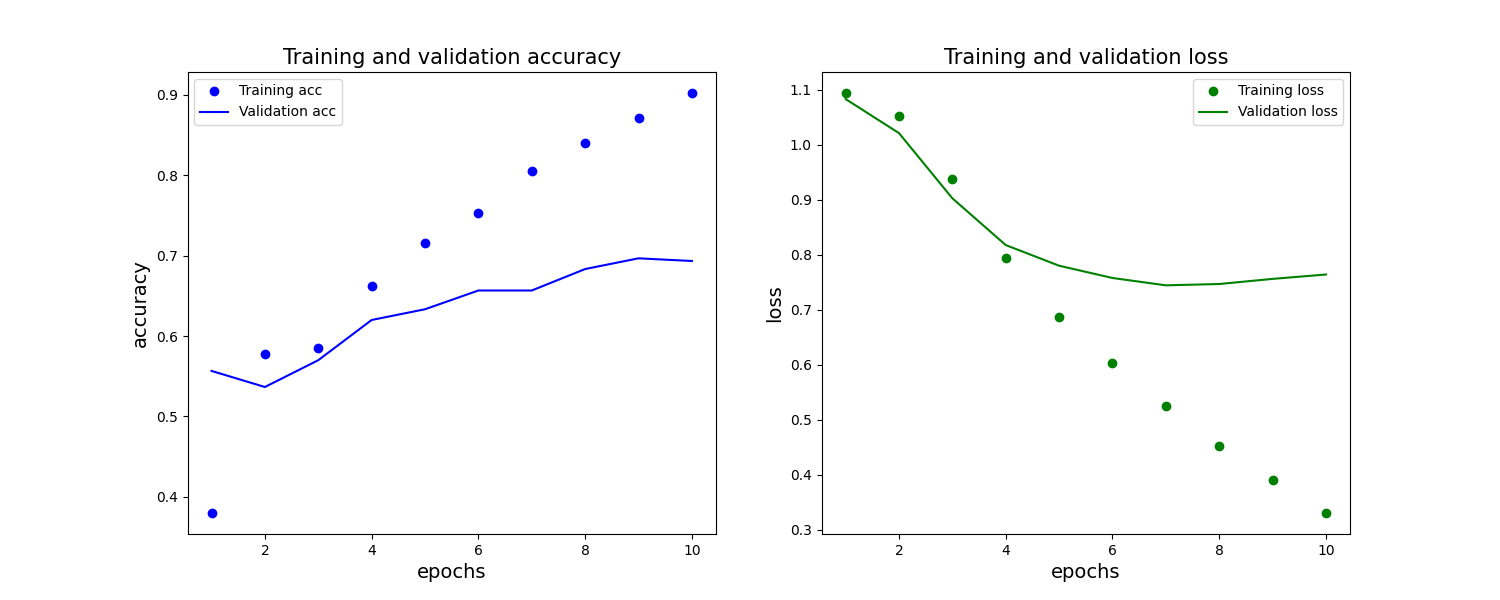

In [120]:
import PIL
from PIL import Image

fp = 'model_single_CNN.png'
PIL.Image.open(fp, mode='r', formats=None)

In [ ]:
model.get_config()

Model 2 to sieć CNN z jedną wartswą aktywacji, dla modelu otrzymałam najwyższą wartość dokłądności i najniższą straty w epoce 6 val_loss: 0.7227 - val_accuracy: 0.7133

In [122]:
model = None
r = None

model = load_model('model_activation_CNN.h5')
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, None, 20)          323200    
                                                                 
 conv1d_11 (Conv1D)          (None, None, 128)         7808      
                                                                 
 global_max_pooling1d_10 (G  (None, 128)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 activation_6 (Activation)   (None, 64)                0         
                                                     

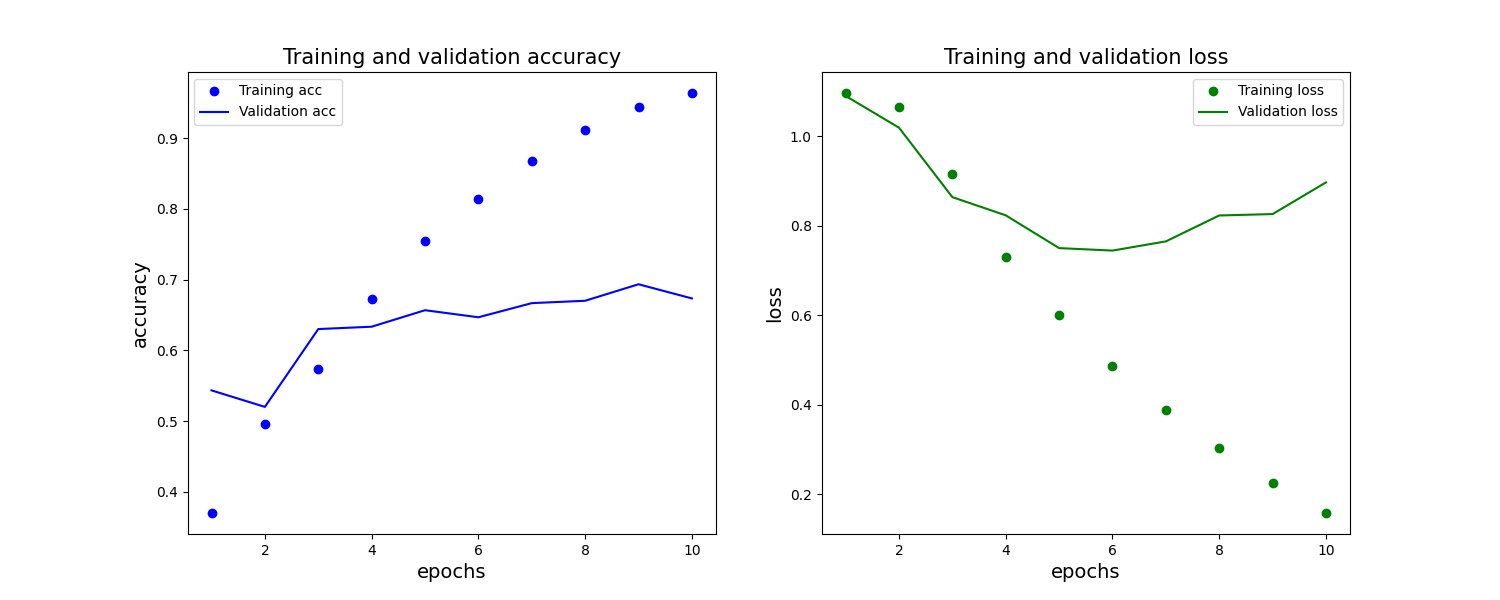

In [123]:
fp = 'model_activation_CNN.png'
PIL.Image.open(fp, mode='r', formats=None)

In [ ]:
model.get_config()

Model 3 to siec CNN zawierająca 2 warstwy aktywacji z dropout, dla której w 5 epoce najwyższa dokładność i najniższa strata wynoszą: val_loss: 0.7875 - val_accuracy: 0.6467

In [125]:
model = None
r = None

model = load_model('model_activation2_CNN.h5')
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, None, 20)          323200    
                                                                 
 conv1d_12 (Conv1D)          (None, None, 128)         7808      
                                                                 
 global_max_pooling1d_11 (G  (None, 128)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 activation_7 (Activation)   (None, 64)                0         
                                                     

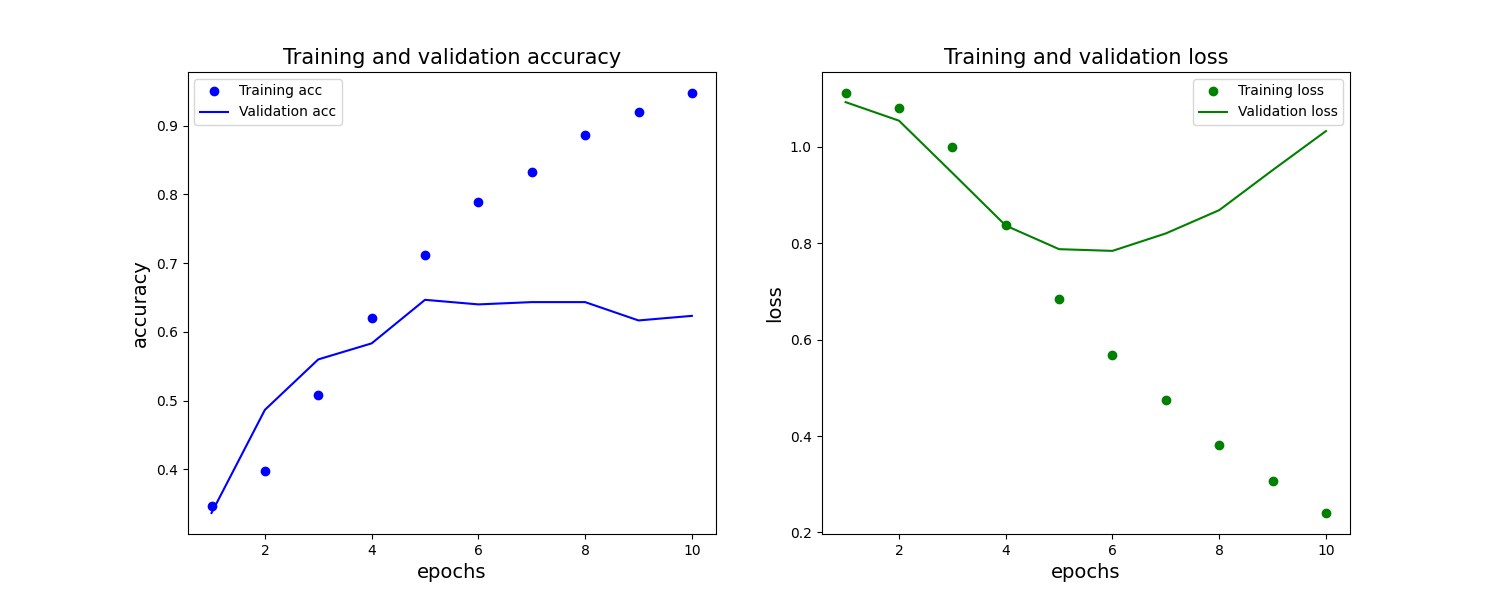

In [126]:
fp = 'model_activation2_CNN.png'
PIL.Image.open(fp, mode='r', formats=None)

In [ ]:
model.get_config()

Podsumowanie modeli

Po przeanalizowaniu 3 wybranych modeli, najniższy wskaźnik val_loss: 0.7227 - val_accuracy: 0.7133 odnotowałam w modelu 2 zawierającym dodatkową warstwe aktywacji wraz z Dropout. Sieć wygląda również na w miarę stabilną, dlatego wybrałam ją do dalszej analizy.

Uwaga: parametry modeli zostały dobrane w taki sposób, aby mogły zostać przeprocesowane przez środowisko wykonawcze google colab. Przy doborze innych parametrów środowisko rozłączało się. Zakładam, że osiągnięte wyniki mogłyby być lepsze dla mocniejszego środowiska.

6. Praca na modelu

Ponieważ model osiągnął najwyższy wynik na epoch 6, dlatego zawężam jego działanie do tego poziomu. Poniżej przechodze ponownie kroki utworzenia modelu.

In [128]:
!pip install -U portalocker>=2.0.0 -q
!pip install torchtext -q

In [129]:
tokenizer = get_tokenizer('spacy', 'en_core_web_sm')

def yield_tokens(data_iter):
  for _, text in data_iter:
    yield tokenizer(text)

In [130]:
data5k.head()

,Review,Rating_class
18296,outstanding hotel stay hotel 2 night june 2008...,Positive
12342,"stay victoria court time far , great location ...",Positive
5872,well travel new york second christmas row stay...,Positive
3712,overall nice time travel riu wedding anniversa...,Positive
9328,thankyou tripadvisor member return 3 day break...,Positive


In [131]:
def lemmatize(text):
  return ' '.join([x.lemma_ for x in nlp(text)])

data5k['Review'] = data5k['Review'].progress_apply(lemmatize)
data5k.head()

100%|██████████| 3000/3000 [01:20<00:00, 37.38it/s]


,Review,Rating_class
18296,outstanding hotel stay hotel 2 night june 2008...,Positive
12342,"stay victoria court time far , great location ...",Positive
5872,well travel new york second christmas row stay...,Positive
3712,overall nice time travel riu wedding anniversa...,Positive
9328,thankyou tripadvisor member return 3 day break...,Positive


In [132]:
data5k['Rating_class'] = data5k['Rating_class'].replace({'Positive':3, 'Neutral':2,
                                                      'Negative': 1})
data5k.head()

,Review,Rating_class
18296,outstanding hotel stay hotel 2 night june 2008...,3
12342,"stay victoria court time far , great location ...",3
5872,well travel new york second christmas row stay...,3
3712,overall nice time travel riu wedding anniversa...,3
9328,thankyou tripadvisor member return 3 day break...,3


In [133]:
data5k['targets'] = data5k['Rating_class'].astype("category").cat.codes

In [134]:
# liczba klas

K = data5k['targets'].max()+1
K

3

In [135]:
data_train, data_test = train_test_split(data5k,test_size = 0.1)

In [136]:
data_train.head()

,Review,Rating_class,targets
7032,secret excellent relax vacation hubby stay sec...,2,1
1472,"customer service smile , friend stay parc st c...",3,2
18288,like hilton position good hotel modern clean l...,2,1
6919,terrific hotel husband spend 20th anniversary ...,3,2
20299,iffy cleanliness stay couple night great locat...,2,1


In [137]:
MAX_VOCAB_SIZE = 2000

tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(data_train['Review'])
sequeces_train = tokenizer.texts_to_sequences(data_train['Review'])
sequeces_test = tokenizer.texts_to_sequences(data_test['Review'])

In [138]:
word2idx = tokenizer.word_index
V = len(word2idx)
print('Znaleziono %s uniktowych tokenów.'%V)

Znaleziono 17014 uniktowych tokenów.


In [139]:
df_train = pad_sequences(sequeces_train)
print('Kształt tensora treningowego:', df_train.shape)

Kształt tensora treningowego: (2700, 1335)


In [140]:
T = df_train.shape[1]
T

1335

In [141]:
df_test = pad_sequences(sequeces_test, maxlen = T)
print('Kształt tensora treningowego:', df_test.shape)

Kształt tensora treningowego: (300, 1335)


In [142]:
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import Bidirectional

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [91]:
model = None
r = None
D = 20


model = Sequential()

model.add(Embedding(V+1,D))
model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64))
model.add(Dropout(0.2))
model.add(Activation('sigmoid'))
model.add(Dense(K))
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, None, 20)          323200    
                                                                 
 conv1d_15 (Conv1D)          (None, None, 128)         7808      
                                                                 
 global_max_pooling1d_14 (G  (None, 128)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 activation_10 (Activation)  (None, 64)                0         
                                                     

In [143]:
model.compile(
    loss = SparseCategoricalCrossentropy(from_logits = True),
    optimizer = 'adam',
    metrics = ['accuracy']
)

print('Training model activation CNN ...')

r = model.fit(
    df_train,
    data_train['targets'],
    epochs = 6,
    batch_size = 64,
    validation_data = (df_test, data_test['targets'])
)

Training model activation CNN ...
Epoch 1/6
43/43 [==============================] - 13s 274ms/step - loss: 1.4743 - accuracy: 0.3981 - val_loss: 1.1524 - val_accuracy: 0.4700
Epoch 2/6
43/43 [==============================] - 11s 247ms/step - loss: 0.9596 - accuracy: 0.5526 - val_loss: 0.9852 - val_accuracy: 0.5267
Epoch 3/6
43/43 [==============================] - 13s 300ms/step - loss: 0.8089 - accuracy: 0.6300 - val_loss: 0.9034 - val_accuracy: 0.5700
Epoch 4/6
43/43 [==============================] - 12s 289ms/step - loss: 0.6927 - accuracy: 0.6907 - val_loss: 0.8843 - val_accuracy: 0.5867
Epoch 5/6
43/43 [==============================] - 11s 247ms/step - loss: 0.5879 - accuracy: 0.7574 - val_loss: 0.8843 - val_accuracy: 0.6000
Epoch 6/6
43/43 [==============================] - 11s 247ms/step - loss: 0.4954 - accuracy: 0.8267 - val_loss: 0.9033 - val_accuracy: 0.5900


In [146]:
def plot_loss_accuracy(r):


  acc = r.history['accuracy']
  val_acc = r.history['val_accuracy']
  loss = r.history['loss']
  val_loss = r.history['val_loss']


  epochs = range(1 ,len(acc) + 1)


  plt.figure(figsize=(15,6))

  plt.subplot(121)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title("Training and validation accuracy", fontsize=15)
  plt.xlabel('epochs', fontsize=14)
  plt.ylabel("accuracy", fontsize=14)
  plt.legend()

  plt.subplot(122)
  plt.plot(epochs, loss, 'go', label='Training loss')
  plt.plot(epochs, val_loss, 'g', label='Validation loss')
  plt.title("Training and validation loss", fontsize=15)
  plt.xlabel('epochs', fontsize=14)
  plt.ylabel("loss", fontsize=14)
  plt.legend()

  plt.savefig("model_final_CNN_e6.png")

  plt.show()

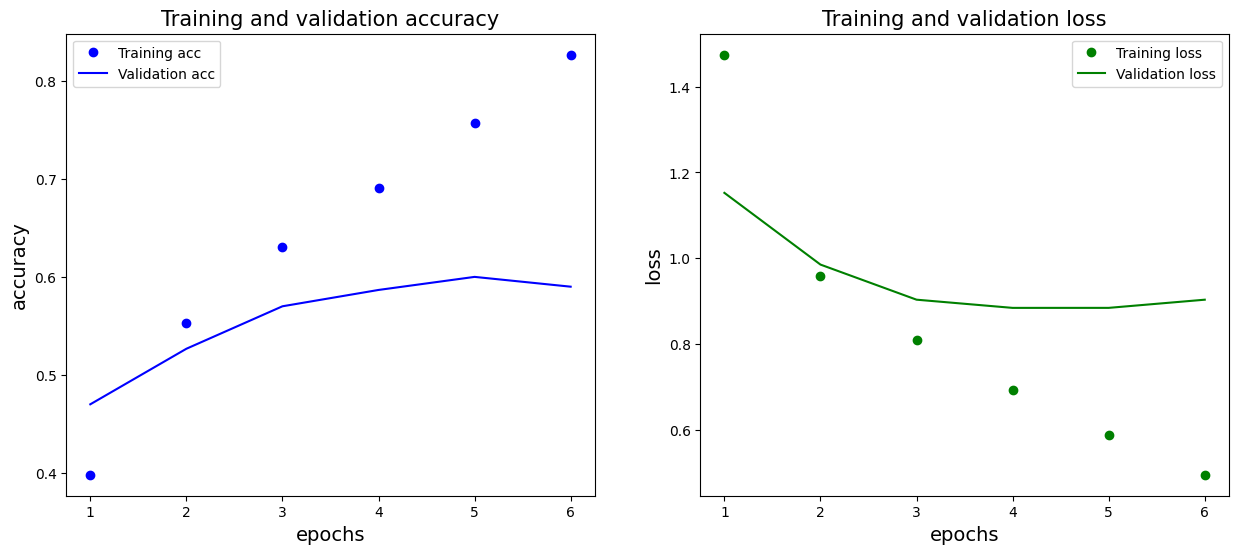

In [147]:
plot_loss_accuracy(r)

Przy wyborze epoch 6 zauważamy spadek dokładności w tej epoce. w związku z tym model powinien zakończyć sie na 5 epoce.

In [148]:
model.save('model_final_CNN_e6.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.get_config()

In [158]:
model = None
r = None
D = 20


model = Sequential()

model.add(Embedding(V+1,D))
model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64))
model.add(Dropout(0.2))
model.add(Activation('sigmoid'))
model.add(Dense(K))
model.summary()

model.compile(
    loss = SparseCategoricalCrossentropy(from_logits = True),
    optimizer = 'adam',
    metrics = ['accuracy']
)

print('Training model activation CNN ...')

r = model.fit(
    df_train,
    data_train['targets'],
    epochs = 5,
    batch_size = 64,
    validation_data = (df_test, data_test['targets'])
)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, None, 20)          340300    
                                                                 
 conv1d_16 (Conv1D)          (None, None, 128)         7808      
                                                                 
 global_max_pooling1d_15 (G  (None, 128)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 activation_11 (Activation)  (None, 64)                0         
                                                     

In [159]:
def plot_loss_accuracy(r):


  acc = r.history['accuracy']
  val_acc = r.history['val_accuracy']
  loss = r.history['loss']
  val_loss = r.history['val_loss']


  epochs = range(1 ,len(acc) + 1)


  plt.figure(figsize=(15,6))

  plt.subplot(121)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title("Training and validation accuracy", fontsize=15)
  plt.xlabel('epochs', fontsize=14)
  plt.ylabel("accuracy", fontsize=14)
  plt.legend()

  plt.subplot(122)
  plt.plot(epochs, loss, 'go', label='Training loss')
  plt.plot(epochs, val_loss, 'g', label='Validation loss')
  plt.title("Training and validation loss", fontsize=15)
  plt.xlabel('epochs', fontsize=14)
  plt.ylabel("loss", fontsize=14)
  plt.legend()

  plt.savefig("model_final_CNN_e5.png")

  plt.show()

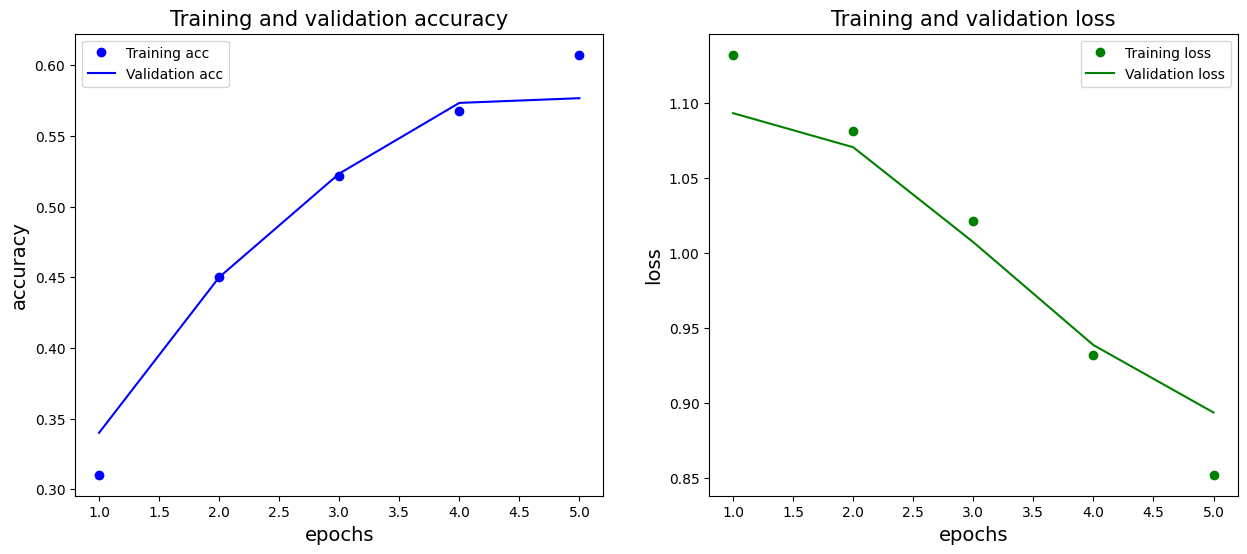

In [160]:
plot_loss_accuracy(r)

In [161]:
model.save('model_final_CNN_e5.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [162]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

model = None
r = None

model = load_model('model_final_CNN_e5.h5')
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, None, 20)          340300    
                                                                 
 conv1d_16 (Conv1D)          (None, None, 128)         7808      
                                                                 
 global_max_pooling1d_15 (G  (None, 128)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 activation_11 (Activation)  (None, 64)                0         
                                                     

7. Analiza sentymentu

In [163]:
criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

In [164]:
data5k.rename(columns={'targets':'label'}, inplace=True)
data5k.rename(columns={'Review':'text'}, inplace=True)
del data5k['Rating_class']
data5k.sample(3)

,text,label
7178,bad well time girlfriend carribean vacation do...,1
1810,"love , hotel on - line stay long weekend late ...",2
9231,"brilliant fabulous , clean lovely room polite ...",2


In [165]:
from datasets import Dataset
dataset_ = Dataset.from_pandas(data5k)
dataset = dataset_.train_test_split(0.1)

In [166]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 2700
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 300
    })
})


In [167]:
model_checkpoint = 'microsoft/deberta-base'
batch_size = 128

In [168]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast = True)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [169]:
tokenizer('recommend hotel reviewer actually stay hotel')

{'input_ids': [1, 43140, 1397, 2303, 37102, 888, 1095, 2303, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [170]:
def process(x):
  return tokenizer(x['text'])

train_ds = dataset['train'].map(process)
eval_ds = dataset['test'].map(process)

Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1241 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [171]:
train_ds

Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2700
})

In [172]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'pooler.dense.weight', 'pooler.dense.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [173]:
!pip install -U accelerate==0.20.1 -q
#!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.5/227.5 kB 4.0 MB/s eta 0:00:00


In [174]:
import transformers
#!pip install -qqq torch==2.0.1 --progress-bar off
#import accelerate 0.20.1

In [175]:
transformers.__version__, accelerate.__version__

('4.35.2', '0.20.3')

In [176]:
args = TrainingArguments(
    f'{model_checkpoint}_sentiment_analysis',
    evaluation_strategy  = 'epoch',
    save_strategy = 'epoch',
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    num_train_epochs  = 5,
    weight_decay  = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy'
)

In [177]:
from datasets import load_metric
import numpy as np

metric = load_metric('glue','sst2')

def compute_metrics(eval_preds):
  logits, labels = eval_preds
  predictions = np.argmax(logits, axis = 1)
  return metric.compute(predictions = predictions, references = labels)

<ipython-input-177-211fb054b740>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('glue','sst2')
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/glue/glue.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [178]:
trainer = Trainer(
    model,
    args,
    train_dataset  = train_ds,
    eval_dataset = eval_ds,
    tokenizer = tokenizer,
    compute_metrics = compute_metrics
)

In [180]:
trainer.evaluate([train_ds[1]])

{'eval_loss': 0.7333858609199524,
 'eval_accuracy': 0.0,
 'eval_runtime': 0.5429,
 'eval_samples_per_second': 1.842,
 'eval_steps_per_second': 1.842}

In [ ]:
trainer.train()

In [182]:
%load_ext tensorboard

In [183]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('logs/demo')

In [184]:
trainer.model

DebertaForSequenceClassification(
  (deberta): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): StableDropout()
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=768, out_features=2304, bias=False)
              (pos_dropout): StableDropout()
              (pos_proj): Linear(in_features=768, out_features=768, bias=False)
              (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): StableDropout()
            )
          )
          (

In [185]:
data5k

,text,label
18296,outstanding hotel stay hotel 2 night june 2008...,2
12342,"stay victoria court time far , great location ...",2
5872,well travel new york second christmas row stay...,2
3712,overall nice time travel riu wedding anniversa...,2
9328,thankyou tripadvisor member return 3 day break...,2
...,...,...
18036,cheat walk ask room staff show nice room 2nd f...,0
17913,average stay stay vincci condal mar 6 night ju...,0
17802,nightmare pleasant husband friend 2 couple boo...,0
15138,drab dreary smell mildew room drab dreary cons...,0


In [186]:
import torch

text = data5k['text'].loc[11837]
inputs = tokenizer(text, return_tensors='pt')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)

with torch.no_grad():
  outputs = model(input_ids=input_ids, attention_mask=attention_mask)
  logits = outputs.logits
  predictions = torch.argmax(logits, dim=-1)

if predictions.item() == 0:
  print("negative example")
elif predictions.item() == 1:
  print("neutral example")
else:
  print("positive example")

negative example


In [187]:
data5k['text'].loc[11837]

'overrate shabby , price room decent hotel room nice city , king room book pay available downgrade single bed insist part - refund , hotel dump old tired shabby warrant star value attach , expensive breakfast cheap hold eat airport , consolation clean ,'

In [188]:
data.iloc[11837]

Review          overrated shabby, price room decent hotel room...
Rating_class                                             Negative
Name: 11837, dtype: object

8. Podsumowanie

Podczas analizy skupiłam sie na znalezieniu optymalnego modelu, który umożliwiłby poprawną klasyfikację sentymentu dotyczącego przekazanych opinii.

Spośród 3 stworzonych modeli wybrałam jeden, którego dokadność jest na poziomie val_accuracy: 0.5767 a strata na poziomie val_loss: 0.8936. Jest to model CNN z dodatkową warstwą aktywacji, dla którego najlepszy wynik osiągnęłam w 5 epoce. w dalszym działaniu modelu dochodziło do jego przeuczenia.

Model w porównniu z modelem BiGRU i BiLSTM osiągnął najgorsze wyniki, dlatego podczas tworzenia modelu do wykorzystania biznesowego nie będę go brała pod uwagę. Oczywiście można jeszcze powalczyć o osiągnięcie wyższej dokładności, jednak na chwilę obecną na tym kończę analizę.
